In [1]:
import torch
from torch.utils.data import DataLoader,Subset,ConcatDataset
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import random_split
import os
import matplotlib.pyplot as plt
PROJECT_DIR = "../../"
RESULT_DIR = "./results-search-design/"
os.makedirs(RESULT_DIR,exist_ok=True)

## Helper class

In [2]:
class Helper:
    def make_fine_grid(self,raw_data, n_corse_x = 3, n_corse_y = 5, n_fine_x = 30, n_fine_y = 80):
        listFG = []  # List Fine Grid
        N = len(raw_data)
        for i in range(N):
            print(f"Pre Processing {i+1:05d}/{N}, {100*(i+1)//N}%",end="\r")
            kirigami_config = raw_data[i, 0:15]
            inner_wCuts = self.corse_to_fine_config(
                kirigami_config, n_corse_x, n_corse_y, n_fine_x, n_fine_y)
            listFG.append(inner_wCuts)

        alldata_FG = np.array(listFG)
        alldata_FG = np.append(alldata_FG, raw_data[:, -3:], 1)
        return alldata_FG

    def corse_to_fine_config(self,kirigami_config, n_corse_x, n_corse_y, n_fine_x, n_fine_y):
        """
        Make Fine Grid using corse grid
        0 5 10     0  80  160 ... 2320
        1 6 11     .  .    .  ... .
        2 7 12  => .  .    .  ... .
        3 8 13     .  .    .  ... .
        4 9 14     79 159 239 ... 2399

        Parameters
        --------------------
        kirigami_config: Corse Kirigami config of size n_corse_x * n_corse_y
        return: Fine grid 1D array of size n_fine_x*n_fine_y
        """
        fine_grid = np.ones((n_fine_x,n_fine_y))
        mx, my = n_fine_x//n_corse_x, n_fine_y//n_corse_y  # 10 16
        zeros = np.array([1]*mx)[:,np.newaxis]
        zeros[mx//3:2*mx//3+1]=0
        # ONLY MAKE CUTS inside the INNER REGION !!
        for index,num in enumerate(kirigami_config):
            if num == 0:
                i_corse_x = index // n_corse_y
                i_corse_y = index % n_corse_y
                fine_grid[mx*i_corse_x:mx*(i_corse_x+1),my*i_corse_y:my*(i_corse_y+1)] = zeros
        return fine_grid.flatten()
helper = Helper()

## Prepare Dataset
We conver coarse grid data to fine grid data using helper class

In [3]:
alldata_15G = np.loadtxt(f'{PROJECT_DIR}/raw/alldata_15G.dat',dtype=np.float32)
alldata_FG = helper.make_fine_grid(alldata_15G)
del alldata_15G
del helper

## Data Cleanup

In [4]:
FEATURES = len(alldata_FG[0])-3
STRAIN, TOUGHNESS, STRESS = -3, -2, -1
prop = STRAIN
max_prop = np.max(alldata_FG[:, prop])
inputs = torch.from_numpy(alldata_FG[:, 0:FEATURES]).float().reshape(-1,1,30,80)
targets = torch.from_numpy(alldata_FG[:, prop]/max_prop).float().reshape(-1,1)
dataset = TensorDataset(inputs,targets)
del inputs,targets,alldata_FG
# print(targets.dtype,inputs.dtype)

# Training and searching

In [5]:
class KirigamiModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 16 x 15 x 40

            nn.Conv2d(16, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 32 x 7 x 20

            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 3 x 10

            nn.Flatten(),
            nn.Linear(1920,64),
            nn.ReLU(),
            nn.Linear(64,1),
        )

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, targets = batch
        preds = self(images)                  # Generate predictions
        loss = F.mse_loss(preds, targets)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, targets = batch
        preds = self(images)                    # Generate predictions
        loss = F.mse_loss(preds, targets)       # Calculate loss
        # acc = accuracy(preds, targets)        # Calculate accuracy
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        # batch_accs = [x['val_acc'] for x in outputs]
        # epoch_acc = torch.stack(batch_accs).mean()    # Combine accuracies
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))
# trial_input = torch.rand((4,1,30,80))
# print(trial_input.dtype)
# model(trial_input).shape

In [6]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            imgs, targets = batch
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
num_samples = 100  # Number of initial samples
num_generations = 10 # Numbers of generations to run to find optimal designs

train_indicies = range(0,100)
test_indicies = range(100,len(dataset))
train_ds_full = Subset(dataset,range(0,100))
test_ds = Subset(dataset,range(100,len(dataset)))
plot_data = np.empty((0,2))
gen_id=0

In [46]:
train_size = int(0.9 * len(train_ds_full))
val_size = len(train_ds_full) - train_size
train_ds, val_ds = random_split(train_ds_full,[train_size,val_size])
train_dl = DataLoader(train_ds,batch_size=50,shuffle=True,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size=10,pin_memory=True)
test_dl = DataLoader(test_ds,batch_size=10)

In [47]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = to_device(KirigamiModel(), device)

In [48]:
history =[]
history += fit(15, 0.001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.0656, val_loss: 0.0528
Epoch [1], train_loss: 0.0361, val_loss: 0.0447
Epoch [2], train_loss: 0.0329, val_loss: 0.0430
Epoch [3], train_loss: 0.0309, val_loss: 0.0388
Epoch [4], train_loss: 0.0293, val_loss: 0.0370
Epoch [5], train_loss: 0.0265, val_loss: 0.0320
Epoch [6], train_loss: 0.0256, val_loss: 0.0292
Epoch [7], train_loss: 0.0226, val_loss: 0.0321
Epoch [8], train_loss: 0.0239, val_loss: 0.0238
Epoch [9], train_loss: 0.0211, val_loss: 0.0233
Epoch [10], train_loss: 0.0203, val_loss: 0.0211
Epoch [11], train_loss: 0.0171, val_loss: 0.0179
Epoch [12], train_loss: 0.0154, val_loss: 0.0155
Epoch [13], train_loss: 0.0138, val_loss: 0.0139
Epoch [14], train_loss: 0.0118, val_loss: 0.0124


In [49]:
preds = torch.tensor([])
for batch in test_dl:
    imgs,targets = batch 
    preds =  torch.cat((preds,model(imgs).detach().flatten().cpu()),dim=0)
print(len(preds))

reals = torch.tensor([])
for batch in train_dl:
    _,targets = batch 
    reals =  torch.cat((reals,targets.flatten().cpu()),dim=0)
for batch in val_dl:
    _,targets = batch 
    reals =  torch.cat((reals,targets.flatten().cpu()),dim=0)
   
print(len(preds),len(reals))


29091
29091 700


In [50]:
y_pred=preds.numpy()

max,_= torch.topk(reals,100)
max=torch.mean(max).item()
plot_data = np.append(plot_data,[[gen_id,max]],axis=0)

sample_indices = np.argpartition(y_pred,-num_samples)[-num_samples:]  # Best Performers

new_train_ds = Subset(test_ds,sample_indices)
print(len(new_train_ds))
train_ds_full = ConcatDataset((train_ds_full,new_train_ds))

mask=torch.ones(len(test_ds))
mask[sample_indices] = 0
test_ds = Subset(test_ds,torch.where(mask == 1)[0])

print(len(train_ds_full))
print(len(test_ds))
gen_id+=1

100
800
28991


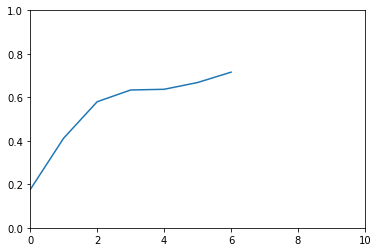

In [52]:
plt.cla()
plt.plot(plot_data[:,0],plot_data[:,1])
plt.xlim(0,10)
plt.ylim(0,1)
plt.savefig("./temp.png",facecolor="White")


## Save the model

In [15]:
# import os
# os.makedirs("./models/regression",exist_ok=True)
# torch.save(model.state_dict(), './models/regression/f16-f32-f64-h64.pth')
